# Unet - Tensorflow 2.x
In this example, you'll see how to compile a public implementation of an Unet Model created for TF2.x to Inferentia (inf1 instances). There is no pre-trained model, so we'll use a toy dataset to create a simple model.

**Reference:** https://github.com/jakeret/unet

## 1) Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
#Install Neuron Tensorflow
%pip install -U tensorflow-neuron==2.5.2.2.1.14.0 neuron-cc
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

### 1.1) Clone the repo

In [ ]:
!git clone https://github.com/jakeret/unet

## 2) Initialize libraries and prepare input samples

In [ ]:
import sys
sys.path.insert(0,'unet/src')
import tensorflow as tf
import tensorflow.neuron as tfn
import matplotlib.pyplot as plt
import numpy as np
import unet
from unet import utils
from unet.datasets import circles
tf.__version__

## 3) Build a new model

### 3.1) Prepare and train the model

In [ ]:
unet_model = unet.build_model(channels=circles.channels,
                              num_classes=circles.classes,
                              layer_depth=3,
                              filters_root=16)
unet.finalize_model(unet_model)
train_dataset, validation_dataset = circles.load_data(100, nx=200, ny=200, splits=(0.7, 0.3))
trainer = unet.Trainer(checkpoint_callback=False)

In [ ]:
trainer.fit(unet_model,
            train_dataset,
            validation_dataset,
            epochs=5,
            batch_size=1)
unet_model.save('unet_circles.h5')

### 3.2) Run the model and plot the results

In [ ]:
def plot_predictions(predictions):
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
    dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

    for i, (image, label) in enumerate(dataset.take(3)):
        ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
        ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
        ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
    plt.tight_layout()

In [ ]:
predictions = unet_model.predict(validation_dataset.batch(batch_size=3))

In [ ]:
plot_predictions(predictions)

## 4) Compile the model for Inferentia with NeuronSDK

In [ ]:
import os

x = validation_dataset.batch(batch_size=1)
x = next(iter(x))[0]

# https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-cc/command-line-reference.html
os.environ["NEURON_CC_FLAGS"] = "--verbose=DEBUG --neuroncore-pipeline-cores=1 --workdir=logs/ --dynamic-batch-size"
neuron_model = tfn.trace(unet_model, x)
neuron_model.save('unet_circles_neuron')

In [ ]:
y = neuron_model(x) # warmup
%timeit neuron_model(x)

## 5) A simple test to check the predictions

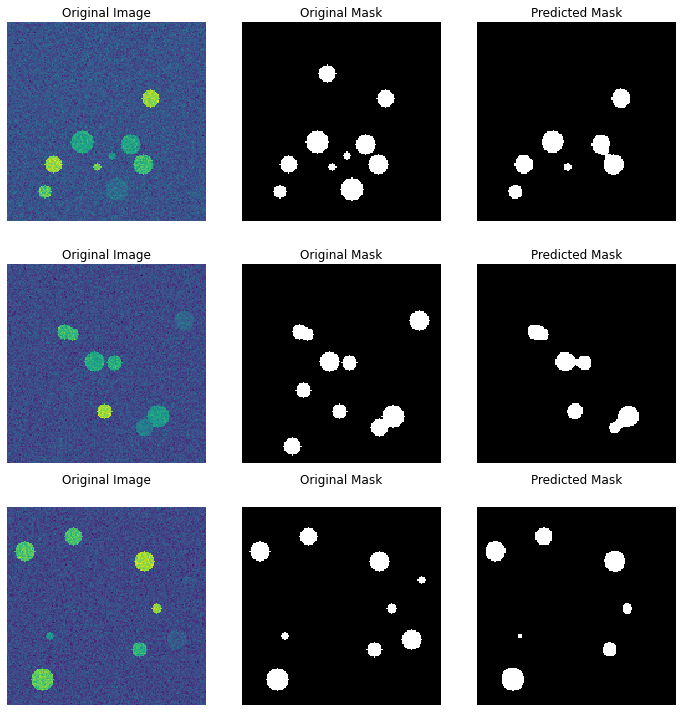

In [16]:
neuron_model = tf.saved_model.load('unet_circles_neuron')
predictions = neuron_model(x)
plot_predictions(predictions)